# Create character feature dataset for STM
Based on fanfiction_gender_roles_data.ipynb

## Postag, parse character assertions
Now in extract_character_features_from_assertions.py

In [1]:
# Load assertions for characters
import json
from tqdm.notebook import tqdm
import os

fandoms = [
    'homestuck',
#     'startrek',
#     'dragonage',
#     'buffy',
#     'jojo',
#     'naruto',
#     'teenwolf',
#     'song_ice_fire',
#     'shadowhunter',
#     'walking_dead'
]
dataset_name = 'complete_en_1k-5k'
for fandom in fandoms:
    pipeline_output_path = f'/data/fanfiction_ao3/{fandom}/{dataset_name}/output/'
    char_assertions = {}
    assertions_dirpath = os.path.join(pipeline_output_path, 'assertion_extraction')

    # for fic, chars in tqdm(fic_chars.items()):
    for fname in tqdm(os.listdir(assertions_dirpath)):
        fic_assertions_path = os.path.join(assertions_dirpath, fname)
    #     if not os.path.exists(fic_assertions_path):
    #         continue

        with open(fic_assertions_path) as f:
            char_assertions[fname[:-5]] = json.load(f)

    len(char_assertions)

  0%|          | 0/22412 [00:00<?, ?it/s]

In [3]:
fic = list(char_assertions.keys())[0]
print(fic)
char_assertions[fic]

229832


{'Nepeta': [{'position': [0, 90],
   'text': "Nepeta was well - attuned to romance - she has to be , to keep a lookout for any possible ships among her friends . Naturally , she was good at spotting quadrant opportunities for herself . After all , had n't she been the first to know that she and Equius were going to be the greatest of moirails , when he was still denying that he held any affection for the troll who kept bothering and bothering and bothering him ? Look how that had turned out !"},
  {'position': [90, 187],
   'text': 'She never had much interest in getting a kismesis or an auspitice , so that was fine for now . A matesprit , though ... Around her were trolls growing flushed feelings for each other , something she watched with amazement . She and her friends were too young to mate , of course , but the electric connection was still there , the intense feelings that drew you to a person and made you want to listen to them for hours and kiss them even when you also wanted t

In [4]:
# Load coref info to replace pronouns with names
pipeline_output_path = f'/data/fanfiction_ao3/{fandom}/{dataset_name}/output/char_coref'
fpath = os.path.join(pipeline_output_path, fic + '.json')
with open(fpath) as f:
    coref = json.load(f)

In [32]:
import pdb

def name_from_char(charname):
    name = ' '.join([part for part in charname.split('_') if part[0].isupper()])
    if name.endswith(')'):
        name = name[:-1]
    return name

def normalize_names(text):
    text_split = text.split()
    
    for i, word in enumerate(text_split):
        if word.startswith('($_'):
            name = name_from_char(word)
            text_split[i-1] = name
            text_split[i] = ''

    return ' '.join(text_split)

# Process assertions
import spacy
from spacy.tokenizer import Tokenizer
import re
nlp = spacy.load('en', disable=['ner'])
nlp.tokenizer = Tokenizer(nlp.vocab, token_match=re.compile(f'\S+').match)

from tqdm.notebook import tqdm
import json

pipeline_output_path = f'/data/fanfiction_ao3/{fandom}/{dataset_name}/output/'

output_dirpath = os.path.join(pipeline_output_path, 'char_features')
if not os.path.exists(output_dirpath):
    os.mkdir(output_dirpath)
    
stops = ['was', 'were', 'to', 'for', 'in', 'on', 'by', 'has', 'had', 'been', 'be', "'re", "'s"]

# for fic in list(char_assertions.keys())[:1]:
for fic in tqdm(char_assertions):
    char_features = {}
    
    # Load coref info to replace pronouns with names
    coref_fpath = os.path.join(pipeline_output_path, 'char_coref', fic + '.json')
    with open(coref_fpath) as f:
        coref = json.load(f)
        
    for char in char_assertions[fic]:
#         name = name_from_char(char)
#         assertions = ' '.join(char_assertions[fic][char])
        for assertion in char_assertions[fic][char]:
            text = assertion['text']
            
            # postag and parse
            annotated = nlp(text)
        
            cluster_matches = [clus for clus in coref['clusters'] if clus.get('name', '') == char]
            if len(cluster_matches) == 0: continue
            cluster = cluster_matches[0]
            mention_inds = [list(range(m['position'][0], m['position'][1])) for m in cluster['mentions']] # token IDs of that character in the text
            mention_inds = [i for el in mention_inds for i in el]
            
            # Verbs where character was the subject
            offset = assertion['position'][0]
            verbs_subj = [tok.head.text.lower() for tok in annotated if tok.i + offset in mention_inds and \
                          (tok.dep_=='nsubj' or tok.dep_=='agent')]

            # Verbs where character was the object
            verbs_obj = [tok.head.text.lower() for tok in annotated if tok.i + offset in mention_inds and \
                         (tok.dep_=='dobj' or tok.dep_=='nsubjpass' or tok.dep_=='dative' or tok.dep_=='pobj')]
#             if len(verbs_obj) > 0:
#                 print(verbs_obj)

            # Adjectives that describe the character
            adjs = [tok.text.lower() for tok in annotated if tok.head.i + offset in mention_inds and \
                    (tok.dep_=='amod' or tok.dep_=='appos' or tok.dep_=='nsubj' or tok.dep_=='nmod')] \
                + [tok.text.lower() for tok in annotated if tok.dep_=='attr' and (tok.head.text=='is' or tok.head.text=='was') and \
                   any([c.i + offset in mention_inds for c in tok.head.children])]

#             if not fic in char_features:
#                 char_features[fic] = {}
            if not char in char_features:
                char_features[char] = []
            
            final_list = [w for w in verbs_subj + verbs_obj + adjs if not w in stops]
            char_features[char].extend(final_list)

    # Save out
    with open(os.path.join(output_dirpath, f'{fic}.json'), 'w') as f:
        json.dump(char_features, f)
        
#     print(char_features)

  0%|          | 0/22412 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [95]:
# Test loading processed JSON files
os.listdir(output_dirpath)

['183523.json',
 '918622.json',
 '309535.json',
 '726061.json',
 '16391837.json',
 '11032020.json',
 '5480774.json',
 '4465862.json',
 '4012087.json',
 '7514581.json',
 '4459220.json',
 '8531686.json',
 '54247.json']

In [98]:
with open(os.path.join(output_dirpath, os.listdir(output_dirpath)[0])) as f:
    test_dict = json.load(f)
    
test_dict

{'Valentines Day': [],
 'Sirius': ['shakes', 'says', 'move'],
 'Remus': ['does',
  'makes',
  'hate',
  'sitting',
  'inserts',
  'remarks',
  'wriggles',
  'continues',
  'is',
  'with'],
 'James': ['explains',
  'concludes',
  'glowers',
  'finishes',
  'buried',
  'asks',
  'jumps',
  'endearing',
  'pines',
  'raced',
  'fights',
  'says',
  'stop',
  'behind',
  'see',
  'of',
  'after'],
 'Evans': ['had', 'into'],
 'God Moony': [],
 'Wormtail': ['got'],
 'Lily': ['been', 'see', 'get', "'re", 'set', 'on', 'hate']}

## Annotate fic relationship type 
Straight or queer, by inferring character gender. Also matches characters in relationship list to pipeline characters

In [1]:
# Load fic metadata
import pandas as pd

fandom = 'homestuck'
dataset = 'complete_en_1k-5k'
metadata_fpath = f'/data/fanfiction_ao3/{fandom}/{dataset}/metadata.csv'
metadata = pd.read_csv(metadata_fpath, index_col='fic_id')
# metadata

# Expand by relationship
metadata['relationships'] = metadata['relationship'].map(eval)

rel_metadata = metadata.explode('relationships')
# rel_metadata

# Filter to fics with romantic relationships
rel_metadata = rel_metadata.dropna(subset=['relationships'])
# rel_metadata

rel_metadata = rel_metadata[rel_metadata['relationships'].map(lambda x: '/' in x or '\\' in x)]
rel_metadata

,title,author,author_key,rating,category,fandom,relationship,character,additional tags,language,...,bookmarks,hits,chapter_count,series,seriespart,seriesid,summary,preface_notes,afterword_notes,relationships
fic_id,,,,,,,,,,,,,,,,,,,,,
17616935,Debauchery At Its Finest,Fox_Salz,Fox_Salz,"[""Explicit""]","[""M/M""]","[""Homestuck""]","[""Orphaner Dualscar/Orphaner Dualscar""]","[""Orphaner Dualscar"", ""The Dolorosa (Homestuck...","[""Self-Indulgent"", ""Self-cest"", ""Timeline Dive...",English,...,NaN,15.0,1,NaN,NaN,NaN,Life changed radically for Dualscar once he fo...,The rarepair sever is responsible for encourag...,Can you believe this is my first homesmut fic?,Orphaner Dualscar/Orphaner Dualscar
17615066,Treasure(d),vantasarcastic,vantasarcastic,"[""General Audiences""]","[""F/M""]","[""Homestuck""]","[""Eridan Ampora/Terezi Pyrope""]","[""Eridan Ampora"", ""Terezi Pyrope""]","[""Emotional Hurt/Comfort"", ""Anxiety"", ""eridan ...",English,...,1.0,59.0,1,NaN,NaN,NaN,Your name is Eridan Ampora and you aren't sure...,hi this is the first time since making this ac...,NaN,Eridan Ampora/Terezi Pyrope
17606096,A Taste of Elmo's World,myheadislostintheclouds,myheadislostintheclouds,"[""Not Rated""]","[""M/M""]","[""Homestuck"", ""Sesame Street (TV)""]","[""Elmo (Sesame Street)/Cronus Ampora""]","[""Elmo (Sesame Street)"", ""Cronus Ampora""]","[""Smut"", ""Vore"", ""Crack Crossover"", ""Crack Rel...",English,...,NaN,25.0,1,NaN,NaN,NaN,he never knew he would find someone this perfe...,"i don't know why i am doing this, why are you ...",i regret writing this\nplease check out my oth...,Elmo (Sesame Street)/Cronus Ampora
17150222,Nerds and Cool Kids,TheDreamWriter1,TheDreamWriter1,"[""Not Rated""]","[""F/F"", ""F/M"", ""M/M""]","[""Homestuck""]","[""Jade Harley/Dave Strider"", ""John Egbert/Rose...","[""John Egbert"", ""Rose Lalonde"", ""Dave Strider""...",[],English,...,NaN,45.0,2,NaN,NaN,NaN,John Egbert is starting his first year at Skai...,(Thank y'all for reading. This story updates o...,NaN,Jade Harley/Dave Strider
17150222,Nerds and Cool Kids,TheDreamWriter1,TheDreamWriter1,"[""Not Rated""]","[""F/F"", ""F/M"", ""M/M""]","[""Homestuck""]","[""Jade Harley/Dave Strider"", ""John Egbert/Rose...","[""John Egbert"", ""Rose Lalonde"", ""Dave Strider""...",[],English,...,NaN,45.0,2,NaN,NaN,NaN,John Egbert is starting his first year at Skai...,(Thank y'all for reading. This story updates o...,NaN,John Egbert/Rose Lalonde
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21651445,Daddy Didn't Love Me,NothingIWontGive,NothingIWontGive,"[""Teen And Up Audiences""]","[""F/F"", ""F/M"", ""M/M""]","[""Homestuck""]","[""Dave Strider/Karkat Vantas"", ""Jane Crocker/R...","[""Dave Strider"", ""Karkat Vantas"", ""Jane Crocke...","[""Domestic Violence"", ""Child Abuse"", ""child po...",English,...,NaN,470.0,1,NaN,NaN,NaN,"His dad never loved him, did he?",NaN,NaN,Jake English/Dirk Strider
21651445,Daddy Didn't Love Me,NothingIWontGive,NothingIWontGive,"[""Teen And Up Audiences""]","[""F/F"", ""F/M"", ""M/M""]","[""Homestuck""]","[""Dave Strider/Karkat Vantas"", ""Jane Crocker/R...","[""Dave Strider"", ""Karkat Vantas"", ""Jane Crocke...","[""Domestic Violence"", ""Child Abuse"", ""child po...",English,...,NaN,470.0,1,NaN,NaN,NaN,"His dad never loved him, did he?",NaN,NaN,Rose Lalonde/Kanaya Maryam
21651445,Daddy Didn't Love Me,NothingIWontGive,NothingIWontGive,"[""Teen And Up Audiences""]","[""F/F"", ""F/M"", ""M/M""]","[""Homestuck""]","[""Dave Strider/Karkat Vantas"", ""Jane Crocker/R...","[""Dave Strider"", ""Karkat Vantas"", ""Jane Crocke...","[""Domestic Violence"", ""Child Abuse"", ""child po...",English,...,NaN,470.0,1,NaN,NaN,NaN,"His dad never loved him, did he?",NaN,NaN,Cronus Ampora/Kankri Vantas


In [5]:
# Try to match chars in relationships with pipeline coreference output
import re

def characters_match(char1, char2):
    """ Returns True if 2 character names match closely enough.
        First splits character names into parts by underscores or spaces.
        Matches either if:
            * Any part matches and either name has only 1 part (Potter and Harry Potte    r, e.g.)
            * The number of part matches is higher than half of unique name parts betw    een the 2 characters
        From /projects/fanfiction-nlp-evaluation/annotated_span.py
    """
    honorifics = ['ms.', 'ms',
                    'mr.', 'mr',
                    'mrs.', 'mrs',
                    'uncle', 'aunt',
                    'dear', 'sir', "ma'am"
                ]
    char1_processed = re.sub(r'[\(\),]', '', char1)
    char1_parts = [part for part in re.split(r'[ _]', char1_processed.lower()) if not     part in honorifics]
    char2_processed = re.sub(r'[\(\),]', '', char2)
    char2_parts = [part for part in re.split(r'[ _]', char2_processed.lower()) if not     part in honorifics]

    # Count number of part matches
    n_parts_match = 0
    for part1 in char1_parts:
        for part2 in char2_parts:
            #if part1 == part2 and len(char1_parts)==1 or len(char2_parts)==1:
            if part1 == part2:
                n_parts_match += 1

    # Determine match
    not_surnames = ['male', 'female']
    if n_parts_match == 1 and (len(char1_parts) == 1 or len(char2_parts) == 1) and not     any([w in char1_parts for w in not_surnames]) and not any([w in char2_parts for w in     not_surnames]):
        match = True
    elif n_parts_match > len(set(char1_parts + char2_parts))/2:
        match = True
    else:
        match = False

    return match

import json
import os
import pdb
from tqdm.notebook import tqdm

# Load coref pipeline info
coref_dirpath = f'/data/fanfiction_ao3/{fandom}/{dataset}/output/char_coref'

def match_coref_chars(fic_id, rel):
    """ Try to find character matches from pipeline output.
        Returns a list of matching characters in the same order as listed in the relationship.
    """
    rel_chars = set([c for c in re.split(r'[\/]', rel)])
    if len(rel_chars) != 2: # Only handle 2-partner relationships as of now
        return [[], []]
    
    coref_fpath = os.path.join(coref_dirpath, f'{fic_id}.json')
    if not os.path.exists(coref_fpath):
        return [[], []]
    with open(coref_fpath) as f:
        coref = json.load(f)
    coref_names = [cluster['name'] for cluster in coref['clusters'] if 'name' in cluster]
    
    rel_matches = list()
    for char in rel_chars:
        matches = list(set([coref_char for coref_char in coref_names if characters_match(char, coref_char)]))
        if len(matches) >= 1:
            rel_matches.append(matches)
        else:
            rel_matches.append([])
#             if len(matches) == 1:
#                 rel_matches[char] = matches
#             if len(matches) > 1:
#                 rel_matches[char] = matches
#                 firstname = str(char.split()[0]).lower()
#                 if all([firstname == match.split()[0].lower() for match in matches]): # first name match
#                     rel_matches[char] = matches
#                 else:
#                     pdb.set_trace()
    return rel_matches

matching_chars = [match_coref_chars(fic_id, rel) for fic_id, rel in tqdm(list(zip(rel_metadata.index, rel_metadata['relationships'])))]
matching_chars

  0%|          | 0/25132 [00:00<?, ?it/s]

[[[], []],
 [['Terezi'], []],
 [['Elmo'], ['Cronus']],
 [['Jade'], ['Dave']],
 [['Rose Lalonde', 'Rose'], ['John Egbert', 'John']],
 [['Jade'], ['Rose Lalonde', 'Rose']],
 [['John Egbert', 'John'], ['Dave']],
 [['Xefros'], ['Dammek']],
 [[], ['Vikare']],
 [['Clubs'], ['Diamonds']],
 [['Jude'], ['Joey']],
 [[], []],
 [['Karkat'], ['Terezi']],
 [['Jade Harley', 'Jade'], ['Rose']],
 [['John'], ['Dirk']],
 [['Sollux'], ['Eridan']],
 [[], ['Dirk']],
 [[], ['Dave', 'DAVE']],
 [['Dave'], ['Bro']],
 [['Bro'], ['Dave']],
 [['Bro'], ['Dave']],
 [['Horuss'], ['Rufioh']],
 [['Rufioh'], ['Damara']],
 [['Dirk'], ['Cronus']],
 [['Jake'], ['Dirk']],
 [['Egbert', 'John'], ['Dave']],
 [['Jake'], ['Dirk']],
 [['John'], ['Dirk']],
 [[], []],
 [['Stelsa'], ['Tyzias']],
 [['Sollux Captor'], ['Eridan']],
 [['Cronus'], ['Damara']],
 [['Karkat'], ['Dave', 'DAVE']],
 [['Jade'], []],
 [['Dualscar'], []],
 [['Dualscar'], []],
 [['Marvus'], []],
 [['John'], ['Vriska']],
 [['Rose'], ['Kanaya']],
 [['Jane'], ['Roxy'

In [8]:
# Filter out relationships with no matching characters for at least
rel_metadata['coref_char_matches'] = matching_chars
filtered = rel_metadata[rel_metadata['coref_char_matches'].map(lambda x: len(x[0])>=1 and len(x[1])>=1)]
filtered

,title,author,author_key,rating,category,fandom,relationship,character,additional tags,language,...,hits,chapter_count,series,seriespart,seriesid,summary,preface_notes,afterword_notes,relationships,coref_char_matches
fic_id,,,,,,,,,,,,,,,,,,,,,
17606096,A Taste of Elmo's World,myheadislostintheclouds,myheadislostintheclouds,"[""Not Rated""]","[""M/M""]","[""Homestuck"", ""Sesame Street (TV)""]","[""Elmo (Sesame Street)/Cronus Ampora""]","[""Elmo (Sesame Street)"", ""Cronus Ampora""]","[""Smut"", ""Vore"", ""Crack Crossover"", ""Crack Rel...",English,...,25.0,1,NaN,NaN,NaN,he never knew he would find someone this perfe...,"i don't know why i am doing this, why are you ...",i regret writing this\nplease check out my oth...,Elmo (Sesame Street)/Cronus Ampora,"[[Elmo], [Cronus]]"
17150222,Nerds and Cool Kids,TheDreamWriter1,TheDreamWriter1,"[""Not Rated""]","[""F/F"", ""F/M"", ""M/M""]","[""Homestuck""]","[""Jade Harley/Dave Strider"", ""John Egbert/Rose...","[""John Egbert"", ""Rose Lalonde"", ""Dave Strider""...",[],English,...,45.0,2,NaN,NaN,NaN,John Egbert is starting his first year at Skai...,(Thank y'all for reading. This story updates o...,NaN,Jade Harley/Dave Strider,"[[Jade], [Dave]]"
17150222,Nerds and Cool Kids,TheDreamWriter1,TheDreamWriter1,"[""Not Rated""]","[""F/F"", ""F/M"", ""M/M""]","[""Homestuck""]","[""Jade Harley/Dave Strider"", ""John Egbert/Rose...","[""John Egbert"", ""Rose Lalonde"", ""Dave Strider""...",[],English,...,45.0,2,NaN,NaN,NaN,John Egbert is starting his first year at Skai...,(Thank y'all for reading. This story updates o...,NaN,John Egbert/Rose Lalonde,"[[Rose Lalonde, Rose], [John Egbert, John]]"
17150222,Nerds and Cool Kids,TheDreamWriter1,TheDreamWriter1,"[""Not Rated""]","[""F/F"", ""F/M"", ""M/M""]","[""Homestuck""]","[""Jade Harley/Dave Strider"", ""John Egbert/Rose...","[""John Egbert"", ""Rose Lalonde"", ""Dave Strider""...",[],English,...,45.0,2,NaN,NaN,NaN,John Egbert is starting his first year at Skai...,(Thank y'all for reading. This story updates o...,NaN,Jade Harley/Rose Lalonde,"[[Jade], [Rose Lalonde, Rose]]"
17150222,Nerds and Cool Kids,TheDreamWriter1,TheDreamWriter1,"[""Not Rated""]","[""F/F"", ""F/M"", ""M/M""]","[""Homestuck""]","[""Jade Harley/Dave Strider"", ""John Egbert/Rose...","[""John Egbert"", ""Rose Lalonde"", ""Dave Strider""...",[],English,...,45.0,2,NaN,NaN,NaN,John Egbert is starting his first year at Skai...,(Thank y'all for reading. This story updates o...,NaN,John Egbert/Dave Strider,"[[John Egbert, John], [Dave]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21651445,Daddy Didn't Love Me,NothingIWontGive,NothingIWontGive,"[""Teen And Up Audiences""]","[""F/F"", ""F/M"", ""M/M""]","[""Homestuck""]","[""Dave Strider/Karkat Vantas"", ""Jane Crocker/R...","[""Dave Strider"", ""Karkat Vantas"", ""Jane Crocke...","[""Domestic Violence"", ""Child Abuse"", ""child po...",English,...,470.0,1,NaN,NaN,NaN,"His dad never loved him, did he?",NaN,NaN,Dave Strider/Karkat Vantas,"[[Karkat], [Dave]]"
21651445,Daddy Didn't Love Me,NothingIWontGive,NothingIWontGive,"[""Teen And Up Audiences""]","[""F/F"", ""F/M"", ""M/M""]","[""Homestuck""]","[""Dave Strider/Karkat Vantas"", ""Jane Crocker/R...","[""Dave Strider"", ""Karkat Vantas"", ""Jane Crocke...","[""Domestic Violence"", ""Child Abuse"", ""child po...",English,...,470.0,1,NaN,NaN,NaN,"His dad never loved him, did he?",NaN,NaN,Jane Crocker/Roxy Lalonde,"[[Jane], [Roxy]]"
21651445,Daddy Didn't Love Me,NothingIWontGive,NothingIWontGive,"[""Teen And Up Audiences""]","[""F/F"", ""F/M"", ""M/M""]","[""Homestuck""]","[""Dave Strider/Karkat Vantas"", ""Jane Crocker/R...","[""Dave Strider"", ""Karkat Vantas"", ""Jane Crocke...","[""Domestic Violence"", ""Child Abuse"", ""child po...",English,...,470.0,1,NaN,NaN,NaN,"His dad never loved him, did he?",NaN,NaN,Jake English/Dirk Strider,"[[Jake], [Dirk]]"


In [25]:
# Annotate relationships with genders

def annotate_relationship_gender(fic_id, rel):
    """ Annotate character pipeline names for genders, return straight if F/M, queer otherwise (including nonbinary) """
    # Load coref 
    coref_fpath = os.path.join(coref_dirpath, f'{fic_id}.json')
    with open(coref_fpath) as f:
        coref = json.load(f)
    char1, char2 = rel
    char1_mentions = [m for mentions in [cluster['mentions'] for cluster in coref['clusters'] if 'name' in cluster and cluster['name'] in char1] for m in mentions]
    char2_mentions = [m for mentions in [cluster['mentions'] for cluster in coref['clusters'] if 'name' in cluster and cluster['name'] in char2] for m in mentions]
    char1_mentions = [m['text'] if 'text' in m else m['phrase'] for m in char1_mentions]
    char2_mentions = [m['text'] if 'text' in m else m['phrase'] for m in char2_mentions]
    char1_gender = infer_gender(char1_mentions)
    char2_gender = infer_gender(char2_mentions)
    
    if (char1_gender == 'F' and char2_gender == 'M') or (char2_gender == 'F' and char1_gender == 'M'):
        return 'straight'
    else:
        return 'queer'

In [11]:
def infer_gender(mentions):
    """ Infer gender based on pronouns in character mentions """
    male_pronouns = ['he', 'him', 'his']
    female_pronouns = ['she', 'her', 'hers']
    nonbinary_pronouns = ['they', 'them', 'their', 'theirs']
    lowered_mentions = [m.lower() for m in mentions]
    male_count = sum(mentions.count(p) for p in male_pronouns)
    female_count = sum(mentions.count(p) for p in female_pronouns)
    nonbinary_count = sum(mentions.count(p) for p in nonbinary_pronouns)
    if male_count > female_count and male_count > nonbinary_count:
        return 'M'
    if female_count > male_count and female_count > nonbinary_count:
        return 'F'
    if nonbinary_count > male_count and nonbinary_count > female_count:
        return 'NB'

In [26]:
filtered['relationship_type'] = [annotate_relationship_gender(fic_id, rel) for fic_id, rel in tqdm(list(zip(filtered.index,
                                                                                                            filtered.coref_char_matches)))]

  0%|          | 0/14812 [00:00<?, ?it/s]

/usr0/home/mamille2/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [28]:
filtered['relationship_type'].value_counts()

queer       11728
straight     3084
Name: relationship_type, dtype: int64

In [29]:
filtered.columns

Index(['title', 'author', 'author_key', 'rating', 'category', 'fandom',
       'relationship', 'character', 'additional tags', 'language', 'published',
       'status', 'status date', 'words', 'comments', 'kudos', 'bookmarks',
       'hits', 'chapter_count', 'series', 'seriespart', 'seriesid', 'summary',
       'preface_notes', 'afterword_notes', 'relationships',
       'coref_char_matches', 'relationship_type'],
      dtype='object')

In [36]:
# Explode to characters
char_metadata = filtered.explode('coref_char_matches')
char_metadata


,title,author,author_key,rating,category,fandom,relationship,character,additional tags,language,...,chapter_count,series,seriespart,seriesid,summary,preface_notes,afterword_notes,relationships,coref_char_matches,relationship_type
fic_id,,,,,,,,,,,,,,,,,,,,,
17606096,A Taste of Elmo's World,myheadislostintheclouds,myheadislostintheclouds,"[""Not Rated""]","[""M/M""]","[""Homestuck"", ""Sesame Street (TV)""]","[""Elmo (Sesame Street)/Cronus Ampora""]","[""Elmo (Sesame Street)"", ""Cronus Ampora""]","[""Smut"", ""Vore"", ""Crack Crossover"", ""Crack Rel...",English,...,1,NaN,NaN,NaN,he never knew he would find someone this perfe...,"i don't know why i am doing this, why are you ...",i regret writing this\nplease check out my oth...,Elmo (Sesame Street)/Cronus Ampora,[Elmo],queer
17606096,A Taste of Elmo's World,myheadislostintheclouds,myheadislostintheclouds,"[""Not Rated""]","[""M/M""]","[""Homestuck"", ""Sesame Street (TV)""]","[""Elmo (Sesame Street)/Cronus Ampora""]","[""Elmo (Sesame Street)"", ""Cronus Ampora""]","[""Smut"", ""Vore"", ""Crack Crossover"", ""Crack Rel...",English,...,1,NaN,NaN,NaN,he never knew he would find someone this perfe...,"i don't know why i am doing this, why are you ...",i regret writing this\nplease check out my oth...,Elmo (Sesame Street)/Cronus Ampora,[Cronus],queer
17150222,Nerds and Cool Kids,TheDreamWriter1,TheDreamWriter1,"[""Not Rated""]","[""F/F"", ""F/M"", ""M/M""]","[""Homestuck""]","[""Jade Harley/Dave Strider"", ""John Egbert/Rose...","[""John Egbert"", ""Rose Lalonde"", ""Dave Strider""...",[],English,...,2,NaN,NaN,NaN,John Egbert is starting his first year at Skai...,(Thank y'all for reading. This story updates o...,NaN,Jade Harley/Dave Strider,[Jade],straight
17150222,Nerds and Cool Kids,TheDreamWriter1,TheDreamWriter1,"[""Not Rated""]","[""F/F"", ""F/M"", ""M/M""]","[""Homestuck""]","[""Jade Harley/Dave Strider"", ""John Egbert/Rose...","[""John Egbert"", ""Rose Lalonde"", ""Dave Strider""...",[],English,...,2,NaN,NaN,NaN,John Egbert is starting his first year at Skai...,(Thank y'all for reading. This story updates o...,NaN,Jade Harley/Dave Strider,[Dave],straight
17150222,Nerds and Cool Kids,TheDreamWriter1,TheDreamWriter1,"[""Not Rated""]","[""F/F"", ""F/M"", ""M/M""]","[""Homestuck""]","[""Jade Harley/Dave Strider"", ""John Egbert/Rose...","[""John Egbert"", ""Rose Lalonde"", ""Dave Strider""...",[],English,...,2,NaN,NaN,NaN,John Egbert is starting his first year at Skai...,(Thank y'all for reading. This story updates o...,NaN,John Egbert/Rose Lalonde,"[Rose Lalonde, Rose]",queer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21651445,Daddy Didn't Love Me,NothingIWontGive,NothingIWontGive,"[""Teen And Up Audiences""]","[""F/F"", ""F/M"", ""M/M""]","[""Homestuck""]","[""Dave Strider/Karkat Vantas"", ""Jane Crocker/R...","[""Dave Strider"", ""Karkat Vantas"", ""Jane Crocke...","[""Domestic Violence"", ""Child Abuse"", ""child po...",English,...,1,NaN,NaN,NaN,"His dad never loved him, did he?",NaN,NaN,Jake English/Dirk Strider,[Dirk],queer
21651445,Daddy Didn't Love Me,NothingIWontGive,NothingIWontGive,"[""Teen And Up Audiences""]","[""F/F"", ""F/M"", ""M/M""]","[""Homestuck""]","[""Dave Strider/Karkat Vantas"", ""Jane Crocker/R...","[""Dave Strider"", ""Karkat Vantas"", ""Jane Crocke...","[""Domestic Violence"", ""Child Abuse"", ""child po...",English,...,1,NaN,NaN,NaN,"His dad never loved him, did he?",NaN,NaN,Cronus Ampora/Kankri Vantas,[Kankri],queer
21651445,Daddy Didn't Love Me,NothingIWontGive,NothingIWontGive,"[""Teen And Up Audiences""]","[""F/F"", ""F/M"", ""M/M""]","[""Homestuck""]","[""Dave Strider/Karkat Vantas"", ""Jane Crocker/R...","[""Dave Strider"", ""Karkat Vantas"", ""Jane Crocke...","[""Domestic Violence"", ""Child Abuse"", ""child po...",English,...,1,NaN,NaN,NaN,"His dad never loved him, did he?",NaN,NaN,Cronus Ampora/Kankri Vantas,[Cronus],queer


### Merge in character features with relationship type

In [60]:
# Load character features, merge with gender, etc
import os
import json
import pandas as pd
from tqdm.notebook import tqdm
from IPython.core.debugger import set_trace

fandom = 'homestuck'
dataset_name = 'complete_en_1k-5k'
output_path = f'/data/fanfiction_ao3/{fandom}/{dataset_name}/output/char_features'

header = ['fic_id', 'pipeline_character', 'assertion_features']
# outlines = [header]
outlines = []

for fname in tqdm(os.listdir(output_path)):
    fic_id = int(fname.split('.')[0])
    
    with open(os.path.join(output_path, fname)) as f:
        char_features = json.load(f)
              
    for char in char_features:
        feats = ' '.join([feat for feat in char_features[char]])
        if len(feats) < 1: continue
        outlines.append([fic_id, char, str(feats)])
            
char_feats = pd.DataFrame(outlines, columns=header).set_index('fic_id')
char_feats

  0%|          | 0/22412 [00:00<?, ?it/s]

,pipeline_character,assertion_features
fic_id,,
1110882,their,of
1110882,I,left have done
1110882,Karkat,went does working wants
1110882,Tavros,went got
1110882,Dave,than works see
...,...,...
8562985,i,ask hear mean got
8562985,hey gang,got have
8562985,Dirk,ask comes


In [61]:
merged = pd.merge(char_metadata, char_feats, left_index=True, right_index=True) # just on fic_id
# merged

# Filter to just those characters present in coref_char_matches
cond = [char in matches for char, matches in zip(merged.pipeline_character, merged.coref_char_matches)]
data = merged[cond]
data['assertion_features'] = data['assertion_features']
data

/usr0/home/mamille2/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,title,author,author_key,rating,category,fandom,relationship,character,additional tags,language,...,seriespart,seriesid,summary,preface_notes,afterword_notes,relationships,coref_char_matches,relationship_type,pipeline_character,assertion_features
fic_id,,,,,,,,,,,,,,,,,,,,,
89832,ten musical interludes,cosmogyral,cosmogyral,"[""General Audiences""]","[""F/M"", ""Gen""]","[""Homestuck""]","[""Mom/Dad"", ""John Egbert/gC""]","[""Dave Strider"", ""Rose Lalonde"", ""John Egbert""...","[""Nakama"", ""Noncanonical Character Death"", ""Cr...",English,...,NaN,NaN,That iPod shuffle meme for Homestuck.,NaN,NaN,John Egbert/gC,[John],queer,John,know understand of
89832,ten musical interludes,cosmogyral,cosmogyral,"[""General Audiences""]","[""F/M"", ""Gen""]","[""Homestuck""]","[""Mom/Dad"", ""John Egbert/gC""]","[""Dave Strider"", ""Rose Lalonde"", ""John Egbert""...","[""Nakama"", ""Noncanonical Character Death"", ""Cr...",English,...,NaN,NaN,That iPod shuffle meme for Homestuck.,NaN,NaN,John Egbert/gC,[gC],queer,gC,asks screws says thank
98766,to starve and wait for spring,dellaluce,dellaluce,"[""Teen And Up Audiences""]","[""F/M""]","[""Homestuck""]","[""Dave/Jade""]","[""Dave Strider"", ""Jade Harley"", ""Rose Lalonde""]","[""crapsack timeline"", ""Pesterlog""]",English,...,NaN,NaN,"he'll have time to mourn her later, but he'll ...",NaN,NaN,Dave/Jade,[Jade],queer,Jade,waiting needed forgives roasted
98766,to starve and wait for spring,dellaluce,dellaluce,"[""Teen And Up Audiences""]","[""F/M""]","[""Homestuck""]","[""Dave/Jade""]","[""Dave Strider"", ""Jade Harley"", ""Rose Lalonde""]","[""crapsack timeline"", ""Pesterlog""]",English,...,NaN,NaN,"he'll have time to mourn her later, but he'll ...",NaN,NaN,Dave/Jade,[Dave],queer,Dave,listening want wait think finished want
100029,Castlebound,Tenebrais,Tenebrais,"[""General Audiences""]","[""F/M""]","[""Homestuck""]","[""John/Jade"", ""Rose/Dave""]","[""John Egbert"", ""Dave Strider"", ""Rose Lalonde""...","[""Fantasy AU""]",English,...,1.0,4155.0,A look into an alternate universe set in a med...,NaN,NaN,John/Jade,[Jade],straight,Jade,looked see giggled 'm 'm sent follow led know ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28531446,Ain't No Sunshine,TenaciousGoldfish,TenaciousGoldfish,"[""Explicit""]","[""M/M"", ""Other""]","[""Homestuck""]","[""Dave Strider/Karkat Vantas""]","[""Dave Strider"", ""Karkat Vantas""]","[""Trans Karkat Vantas"", ""Smut"", ""Penis In Vagi...",English,...,NaN,NaN,Kk and Dave fuck and that's about it.,This was going to be the first chapter of some...,Could I have made the ending a little happier ...,Dave Strider/Karkat Vantas,[Karkat],queer,Karkat,at at love place at did with wanted without af...
28531446,Ain't No Sunshine,TenaciousGoldfish,TenaciousGoldfish,"[""Explicit""]","[""M/M"", ""Other""]","[""Homestuck""]","[""Dave Strider/Karkat Vantas""]","[""Dave Strider"", ""Karkat Vantas""]","[""Trans Karkat Vantas"", ""Smut"", ""Penis In Vagi...",English,...,NaN,NaN,Kk and Dave fuck and that's about it.,This was going to be the first chapter of some...,Could I have made the ending a little happier ...,Dave Strider/Karkat Vantas,[Dave],queer,Dave,fell did looked thought love supressing looked...
28537029,John\xe2\x80\x99s Gift,DirkyStrider16,DirkyStrider16,"[""Explicit""]","[""M/M""]","[""Homestuck""]","[""Dave's Bro | Beta Dirk Strider/John Egbert""]","[""Dave's Bro | Beta Dirk Strider"", ""John Egbert""]","[""Sex Toys"", ""Established Relationship"", ""Ligh...",English,...,NaN,NaN,John finally finds the perfect gift for his ma...,Merry Christmas! I\xe2\x80\x99m so sorry it\xe...,NaN,Dave's Bro | Beta Dirk Strider/John Egbert,[John],queer,John,loved got john starting bring pulled pulled hu...


In [90]:
merged.loc[106386]

,title,author,author_key,rating,category,fandom,relationship,character,additional tags,language,...,seriespart,seriesid,summary,preface_notes,afterword_notes,relationships,coref_char_matches,relationship_type,pipeline_character,assertion_features
fic_id,,,,,,,,,,,,,,,,,,,,,
106386,we drive by braille,dellaluce,dellaluce,"[""Teen And Up Audiences""]","[""F/M""]","[""Homestuck""]","[""Dave/Jade""]","[""Dave Strider"", ""Jade Harley"", ""Rose Lalonde""...",[],English,...,NaN,NaN,he flicks through his address book looking for...,NaN,NaN,Dave/Jade,[Jade],queer,Typhon,names
106386,we drive by braille,dellaluce,dellaluce,"[""Teen And Up Audiences""]","[""F/M""]","[""Homestuck""]","[""Dave/Jade""]","[""Dave Strider"", ""Jade Harley"", ""Rose Lalonde""...",[],English,...,NaN,NaN,he flicks through his address book looking for...,NaN,NaN,Dave/Jade,[Jade],queer,Hephaestus,remember winning at built of
106386,we drive by braille,dellaluce,dellaluce,"[""Teen And Up Audiences""]","[""F/M""]","[""Homestuck""]","[""Dave/Jade""]","[""Dave Strider"", ""Jade Harley"", ""Rose Lalonde""...",[],English,...,NaN,NaN,he flicks through his address book looking for...,NaN,NaN,Dave/Jade,[Jade],queer,smith - god,god volcanoes etcetera all
106386,we drive by braille,dellaluce,dellaluce,"[""Teen And Up Audiences""]","[""F/M""]","[""Homestuck""]","[""Dave/Jade""]","[""Dave Strider"", ""Jade Harley"", ""Rose Lalonde""...",[],English,...,NaN,NaN,he flicks through his address book looking for...,NaN,NaN,Dave/Jade,[Jade],queer,a man who could 've been you in another life,who
106386,we drive by braille,dellaluce,dellaluce,"[""Teen And Up Audiences""]","[""F/M""]","[""Homestuck""]","[""Dave/Jade""]","[""Dave Strider"", ""Jade Harley"", ""Rose Lalonde""...",[],English,...,NaN,NaN,he flicks through his address book looking for...,NaN,NaN,Dave/Jade,[Jade],queer,your best friend,best
106386,we drive by braille,dellaluce,dellaluce,"[""Teen And Up Audiences""]","[""F/M""]","[""Homestuck""]","[""Dave/Jade""]","[""Dave Strider"", ""Jade Harley"", ""Rose Lalonde""...",[],English,...,NaN,NaN,he flicks through his address book looking for...,NaN,NaN,Dave/Jade,[Jade],queer,your brother,bringing going
106386,we drive by braille,dellaluce,dellaluce,"[""Teen And Up Audiences""]","[""F/M""]","[""Homestuck""]","[""Dave/Jade""]","[""Dave Strider"", ""Jade Harley"", ""Rose Lalonde""...",[],English,...,NaN,NaN,he flicks through his address book looking for...,NaN,NaN,Dave/Jade,[Jade],queer,Bro,told miss said left like liked
106386,we drive by braille,dellaluce,dellaluce,"[""Teen And Up Audiences""]","[""F/M""]","[""Homestuck""]","[""Dave/Jade""]","[""Dave Strider"", ""Jade Harley"", ""Rose Lalonde""...",[],English,...,NaN,NaN,he flicks through his address book looking for...,NaN,NaN,Dave/Jade,[Jade],queer,Jade,confirms tell eat have sniffs smell adds like ...
106386,we drive by braille,dellaluce,dellaluce,"[""Teen And Up Audiences""]","[""F/M""]","[""Homestuck""]","[""Dave/Jade""]","[""Dave Strider"", ""Jade Harley"", ""Rose Lalonde""...",[],English,...,NaN,NaN,he flicks through his address book looking for...,NaN,NaN,Dave/Jade,[Jade],queer,Lalonde,watches adds 'm know


In [73]:
data.columns

Index(['title', 'author', 'author_key', 'rating', 'category', 'fandom',
       'relationship', 'character', 'additional tags', 'language', 'published',
       'status', 'status date', 'words', 'comments', 'kudos', 'bookmarks',
       'hits', 'chapter_count', 'series', 'seriespart', 'seriesid', 'summary',
       'preface_notes', 'afterword_notes', 'relationships',
       'coref_char_matches', 'relationship_type', 'pipeline_character',
       'assertion_features'],
      dtype='object')

In [93]:
# Combine character features for characters that match the same character in a relationship
agg =  {'assertion_features': ' '.join}
# cols to keep
agg.update({col: 'first' for col in [
    'title', 'rating', 'category', 'relationship', 'kudos', 'pipeline_character', 'relationship_type', 'published'
    ]})
gped = data.groupby([data.index, data['coref_char_matches'].astype(str)]).agg(agg)
gped
# data.groupby([data.index, data['coref_char_matches'].astype(str)])['assertion_features'].apply(' '.join)

assertion_features  \
fic_id   coref_char_matches                                                      
89832    ['John']                                           know understand of   
         ['gC']                                         asks screws says thank   
98766    ['Dave']                      listening want wait think finished want   
         ['Jade']                              waiting needed forgives roasted   
100029   ['Jade']            looked see giggled 'm 'm sent follow led know ...   
...                                                                        ...   
28526382 ['Karkat']          smiles nice preferred working worker have arri...   
28531446 ['Dave']            fell did looked thought love supressing looked...   
         ['Karkat']          at at love place at did with wanted without af...   
28537029 ['Dirk', 'Bro']     grew grew cared get around with at pull remind...   
         ['John']            loved got john starting bring pulled pulled hu...   

                                                     title  \
fic_id   coref_char_matches                                  
89832    ['John']                   ten musical interludes   
         ['gC']                     ten musical interludes   
98766    ['Dave']            to starve and wait for spring   
         ['Jade']            to starve and wait for spring   
100029   ['Jade']                              Castlebound   
...                                                    ...   
28526382 ['Karkat']               Long Journey, Grand Tour   
28531446 ['Dave']                        Ain't No Sunshine   
         ['Karkat']                      Ain't No Sunshine   
28537029 ['Dirk', 'Bro']            John\xe2\x80\x99s Gift   
         ['John']                   John\xe2\x80\x99s Gift   

                                                rating          category  \
fic_id   coref_char_matches                                                
89832    ['John']                ["General Audiences"]    ["F/M", "Gen"]   
         ['gC']                  ["General Audiences"]    ["F/M", "Gen"]   
98766    ['Dave']            ["Teen And Up Audiences"]           ["F/M"]   
         ['Jade']            ["Teen And Up Audiences"]           ["F/M"]   
100029   ['Jade']                ["General Audiences"]           ["F/M"]   
...                                                ...               ...   
28526382 ['Karkat']              ["General Audiences"]           ["Gen"]   
28531446 ['Dave']                         ["Explicit"]  ["M/M", "Other"]   
         ['Karkat']                       ["Explicit"]  ["M/M", "Other"]   
28537029 ['Dirk', 'Bro']                  ["Explicit"]           ["M/M"]   
         ['John']                         ["Explicit"]           ["M/M"]   

                                                               relationship  \
fic_id   coref_char_matches                                                   
89832    ['John']                             ["Mom/Dad", "John Egbert/gC"]   
         ['gC']                               ["Mom/Dad", "John Egbert/gC"]   
98766    ['Dave']                                             ["Dave/Jade"]   
         ['Jade']                                             ["Dave/Jade"]   
100029   ['Jade']                                ["John/Jade", "Rose/Dave"]   
...                                                                     ...   
28526382 ['Karkat']                          ["Dave Strider/Karkat Vantas"]   
28531446 ['Dave']                            ["Dave Strider/Karkat Vantas"]   
         ['Karkat']                          ["Dave Strider/Karkat Vantas"]   
28537029 ['Dirk', 'Bro']     ["Dave's Bro | Beta Dirk Strider/John Egbert"]   
         ['John']            ["Dave's Bro | Beta Dirk Strider/John Egbert"]   

                             kudos pipeline_character relationship_type  \
fic_id   coref_char_matches                                               
89832    ['John']  

In [118]:
# Filter to fics with characters only in one relationship
sizes = gped.groupby('fic_id').size()
inds = sizes[sizes%2==0].index.tolist()
filtered = gped.iloc[gped.index.get_level_values('fic_id').isin(inds)]
filtered

assertion_features  \
fic_id   coref_char_matches                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
89832    ['John']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      know understand of   
         ['gC']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [119]:
# Verify there are an even number of chars/fic
filtered.groupby('fic_id').size().value_counts()
# Fics with 1 seem to be errors/rare cases where a character appears in coref (and thus matches the relationship) but doesn't have assertions
# Fics with other odd numbers are where the same character is involved in multiple relationships (maybe put queer then? remove)

2     9617
4      561
6       78
8       18
10       5
12       1
dtype: int64

In [ ]:
# Save out for STM
filtered.to_csv(f'/data')

# Old

## Annotate character gender

### Get names from pipeline

In [1]:
# Annotate characters for gender
# Load all character names

import json
import os
from collections import Counter
from tqdm.notebook import tqdm
from IPython.core.debugger import set_trace

fandoms = [
    'homestuck',
#     'startrek',
#     'dragonage',
#     'buffy',
#     'jojo',
#     'naruto',
#     'teenwolf',
#     'song_ice_fire',
#     'shadowhunter',
#     'walking_dead'
]
for fandom in fandoms:
    pipeline_output_path = f'/data/fanfiction_ao3/{fandom}/complete_en_1k-5k/output'
    output_dirpath = os.path.join(pipeline_output_path, 'char_features')
    character_names = []
    for fname in tqdm(sorted(os.listdir(output_dirpath))):
        with open(os.path.join(output_dirpath, fname)) as f:
            char_features = json.load(f)
        character_names.extend(list(char_features.keys()))
    len(character_names)

  0%|          | 0/22412 [00:00<?, ?it/s]

In [3]:
# Save out
with open('/data/fanfiction_gender_roles/tmp/hp_character_names.json', 'w') as f:
    json.dump(character_names, f)

In [2]:
character_names_ctr = Counter(character_names)
print(len(character_names_ctr))

# Refine characters
# characters_ctr_filtered = [el for el in character_names_ctr.most_common() if el[0] != '' and el[1] > 1]
characters_ctr_filtered = Counter({name: count for name,count in character_names_ctr.items() if name != '' and count > 1})
len(characters_ctr_filtered)

63786


10640

### Get canonical characters from AO3

In [10]:
# Get canonical list of characters from AO3
import urllib.request
from bs4 import BeautifulSoup

fandom = 'homestuck'
url = f'https://archiveofourown.org/tags/{fandom}'
html = urllib.request.urlopen(url).read()
# html

soup = BeautifulSoup(html, 'html.parser')
soup

canonical_chars = [el.text for el in soup.find('div', class_='characters listbox group').find(class_='tags commas index group').find_all('li') \
        if '(' not in el.text and 'Character' not in el.text and el.text != 'and more' and not 'add more as they' in el.text]
print(len(canonical_chars))
canonical_chars

205


['Aimless Renegade',
 'Alpha Bro',
 'Alpha Dave',
 'Alpha Dave Strider',
 'Alpha Guardians',
 'Alpha Kids',
 'Alpha Rose Lalonde',
 'Alpha Trolls',
 'Andrew Hussie',
 'aradia',
 'Aradia Medigo',
 'Aradia Megido',
 'Aradiabot',
 'Aranea Serket',
 'Arcjec Voorat',
 'ARquiusprite',
 'AT',
 'Aurthour',
 'Auto-Responder',
 'Auto-Responder | Lil Hal',
 'Bec Noir',
 'Beforus Aradia Megido',
 'Beforus Eridan Ampora',
 'Beforus Feferi Peixes',
 'Beforus Karkat Vantas',
 'Beforus Sollux Captor',
 'Beforus Terezi Pyrope',
 'Beta Guardians',
 'Beta Kids',
 'Beta Trolls',
 'Betty Crocker',
 'Black King',
 'Black Queen',
 'Brain Ghost Dirk Strider',
 'Bro Strider',
 'Bro | Dirk Strider',
 'Brobot',
 'Caliborn',
 'Caliborn | Lord English',
 'Clubs Deuce',
 'Colonel Sassacre',
 'Courtyard Droll',
 'Crabdad',
 'Cronus Ampora',
 'CT',
 'D Strider',
 'Dad Crocker',
 'Dad Egbert',
 'Damara Megido',
 'Darkleer',
 'Dave Lalonde',
 'Dave Strider',
 "Dave's Bro",
 "Dave's Bro | Beta Dirk Strider",
 'Davepeta'

In [12]:
canonical_character_name_parts = set([part for name in canonical_chars for part in name.split()])
exclude = set(['The'])
canonical_character_name_parts -= exclude
# print(len(canonical_character_name_parts))
# list(canonical_character_name_parts)[:10]

remove = [
         ]

name_transform = { # Might then miss when stories use these terms, though (same with canonicalize): might want to spread gender info afterward
}
    

def canonicalize(name):
    
    name_parts = name.split()
    new_name_parts = []
    
    for name_part in name_parts:
        if name_part in canonical_character_name_parts:
            new_name_parts.append(name_part)
            
    new_name = ' '.join(new_name_parts)
    
    if new_name in remove:
        new_name = ''
        
    if new_name in name_transform:
        new_name = name_transform[new_name]
            
    return new_name

In [5]:
characters_ctr_filtered.most_common(200)

[('Dave', 7344),
 ('You', 6610),
 ('Karkat', 5725),
 ('you', 5330),
 ('We', 4975),
 ('John', 4910),
 ('Rose', 4416),
 ('They', 4397),
 ('we', 3149),
 ('they', 3106),
 ('Dirk', 2933),
 ('Jade', 2740),
 ('I', 2669),
 ('Kanaya', 2643),
 ('Terezi', 2527),
 ('the room', 2209),
 ('Sollux', 2079),
 ('home', 2077),
 ('Vriska', 2053),
 ('Gamzee', 2018),
 ('Roxy', 2013),
 ('Jake', 1761),
 ('Eridan', 1717),
 ('Bro', 1637),
 ('them', 1568),
 ('their', 1506),
 ('here', 1369),
 ('Jane', 1288),
 ('everyone', 1259),
 ('people', 1254),
 ('Aradia', 1230),
 ('someone', 1215),
 ('Nepeta', 1213),
 ('It', 1089),
 ('Equius', 1071),
 ('the kitchen', 1066),
 ('i', 1065),
 ('Feferi', 1055),
 ('Tavros', 1015),
 ('your', 933),
 ('Strider', 807),
 ('Kankri', 806),
 ('the couch', 803),
 ('Everyone', 789),
 ('the world', 740),
 ('Cronus', 720),
 ('TG', 688),
 ('us', 676),
 ('Egbert', 675),
 ('She', 672),
 ('He', 663),
 ('Your', 645),
 ('themselves', 634),
 ('the bathroom', 594),
 ('Alternia', 587),
 ('the bed', 581)

In [13]:
# Remove characters who don't have matches with canonical characters

# Filter, canonicalize names
characters_ctr_matches = Counter()
for name, count in characters_ctr_filtered.items():
    new_name = canonicalize(name)
    
    # Remove names
    if len(new_name) <= 1 or new_name in remove:
        continue
        
    # Transform names
    if new_name in name_transform:
        new_name = name_transform[new_name]
        
    if new_name in characters_ctr_matches:
        characters_ctr_matches[new_name] += count
        
    else:
        characters_ctr_matches[new_name] = count
    
print(len(characters_ctr_matches))
characters_ctr_matches.most_common()

293


[('Dave', 7696),
 ('Karkat', 5948),
 ('John', 5165),
 ('Rose', 4593),
 ('Dirk', 3005),
 ('Jade', 2799),
 ('Kanaya', 2680),
 ('Terezi', 2577),
 ('Sollux', 2149),
 ('Vriska', 2109),
 ('Gamzee', 2072),
 ('Roxy', 2057),
 ('Bro', 1828),
 ('Jake', 1800),
 ('Eridan', 1774),
 ('Jane', 1344),
 ('Aradia', 1260),
 ('Nepeta', 1249),
 ('Equius', 1097),
 ('Feferi', 1065),
 ('Tavros', 1046),
 ('Strider', 1045),
 ('Kankri', 842),
 ('Egbert', 820),
 ('Cronus', 737),
 ('Dad', 488),
 ('Meenah', 483),
 ('Porrim', 459),
 ('Mituna', 415),
 ('Kurloz', 396),
 ('Dave Strider', 367),
 ('Lalonde', 336),
 ('Vantas', 326),
 ('Latula', 301),
 ('Hal', 297),
 ('Damara', 277),
 ('Mom', 267),
 ('Meulin', 265),
 ('Aranea', 256),
 ('Slick', 250),
 ('Condesce', 248),
 ('Signless', 235),
 ('Harley', 230),
 ('Jack', 226),
 ('John Egbert', 224),
 ('Ampora', 224),
 ('Dualscar', 209),
 ('Rufioh', 206),
 ('Mindfang', 203),
 ('Davesprite', 203),
 ('Karkat Vantas', 198),
 ('Bec', 179),
 ('Droog', 165),
 ('Cal', 161),
 ('Captor', 

In [9]:
# Load canonical list of characters
char_list_fpath = '/projects/fanfiction_gender_roles/scripts/harrypotter_characters.txt' # Came from AO3 fandom tag page, probably filtered
with open(char_list_fpath) as f:
    canonical_characters = f.read().splitlines()
    
extra = ['Dobby']
remove = ['Hogwarts', 'Slytherin', 'Gryffindor', 'Order', 'The',
         'The Slytherin',
          'The Headmaster',
         ]
canonical_characters += extra
canonical_characters = [c for c in canonical_characters if not c in remove]

len(canonical_characters)

116251


245

### Get character gender from Wikia FANDOM

In [18]:
fandom

'homestuck'

In [29]:
# Get gender from wikia page
import urllib.request
from bs4 import BeautifulSoup
from tqdm import tqdm_notebook as tqdm
from IPython.core.debugger import set_trace
import time
import urllib.error

wikia_fandom_names = {
    'homestuck': 'mspaintadventures',
    'startrek': 'memoryalpha',
}

character_gender = {} # Keys are character names from character features
characters_no_genderbox = []
characters_http_error = []

for character in tqdm([name for name, count in characters_ctr_matches.most_common()][:1]):
    
    if character in character_gender: continue
    if character in characters_no_genderbox: continue
    if character in characters_http_error: continue
    
    try:
        
        url = f'https://{wikia_fandom_names[fandom]}.fandom.com/wiki/{character.replace(" ", "_")}'
        html_str = urllib.request.urlopen(url).read()
    except urllib.error.HTTPError as e:
        characters_http_error.append(character)
        print(f'Character {character} HTTP error')
        
    soup = BeautifulSoup(html_str, 'html.parser')
    
    if soup is None:
        print(html_str)
        break

    # div = list(soup.find('div', {'data-source':"gender"}).children)
    # soup.find('div', {'data-source':"gender"}).text
    genderbox = soup.find('div', {'data-source':"gender"})
    if genderbox is None:
        print(f'Character {character} has no gender box')
        characters_no_genderbox.append(character)
    else:
        gender = genderbox.find('div').text.lower()

/usr0/home/mamille2/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1 [00:00<?, ?it/s]

Character Dave has no gender box


<!DOCTYPE html>

<html class="client-nojs" dir="ltr" lang="en">
<head>
<meta charset="utf-8"/>
<title>Dave Strider | MS Paint Adventures Wiki | Fandom</title>
<script>document.documentElement.className = document.documentElement.className.replace( /(^|\s)client-nojs(\s|$)/, "$1client-js$2" );</script>
<script>(window.RLQ=window.RLQ||[]).push(function(){mw.config.set({"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":false,"wgNamespaceNumber":0,"wgPageName":"Dave_Strider","wgTitle":"Dave Strider","wgCurRevisionId":247678,"wgRevisionId":247678,"wgArticleId":3057,"wgIsArticle":true,"wgIsRedirect":false,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Homestuck characters","Humans","Sprite components"],"wgBreakFrames":false,"wgPageContentLanguage":"en","wgPageContentModel":"wikitext","wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August
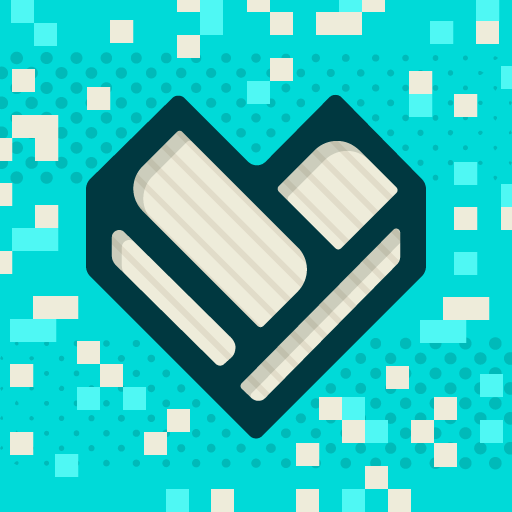
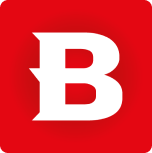

In [30]:
soup

In [33]:
list([el for el in soup.find_all('b')])

[<b>Act 1</b>,
 <b>Act 2</b>,
 <b>Act 3</b>,
 <b>Act 4</b>,
 <b>Act 5 Act 2</b>,
 <b>Act 6 Intermission 1</b>,
 <b>Act 6 Intermission 2</b>,
 <b>Act 6 Act 3</b>,
 <b>Act 6 Intermission 3</b>,
 <b>Act 6 Intermission 5</b>,
 <b>Act 6 Act 6 Intermission 1</b>,
 <b>Act 6 Act 6 Intermission 2</b>,
 <b>Act 6 Act 6 Intermisson 4</b>,
 <b>Act 6 Act 6 Intermission 5</b>,
 <b>Dave Strider</b>,
 <b>Heart</b>]

In [36]:
toc = soup.find(id='toc')
toc

<div class="toc" id="toc"><input class="toctogglecheckbox" id="toctogglecheckbox" role="button" style="display:none" type="checkbox"><div class="toctitle" dir="ltr" lang="en"><h2>Contents</h2><span class="toctogglespan"><label class="toctogglelabel" for="toctogglecheckbox"></label></span></div>
<ul>
<li class="toclevel-1 tocsection-1"><a href="#Biography"><span class="tocnumber">1</span> <span class="toctext">Biography</span></a>
<ul>
<li class="toclevel-2 tocsection-2"><a href="#Childhood"><span class="tocnumber">1.1</span> <span class="toctext">Childhood</span></a></li>
<li class="toclevel-2 tocsection-3"><a href="#Pre-Entry"><span class="tocnumber">1.2</span> <span class="toctext">Pre-Entry</span></a></li>
<li class="toclevel-2 tocsection-4"><a href="#Entry"><span class="tocnumber">1.3</span> <span class="toctext">Entry</span></a></li>
<li class="toclevel-2 tocsection-5"><a href="#The_three-year_journey"><span class="tocnumber">1.4</span> <span class="toctext">The three-year journey

In [40]:
aside = soup.find('aside')
aside

<aside class="portable-infobox pi-background pi-theme-mspa pi-layout-default" role="region">
<h2 class="pi-item pi-item-spacing pi-title" data-source="name"><div class="iconLeft"><a class="image" href="https://static.wikia.nocookie.net/mspaintadventures/images/e/e1/DaveLogoSlashed.png/revision/latest?cb=20180325021719"><img alt="DaveLogoSlashed.png" class="lazyload" data-image-key="DaveLogoSlashed.png" data-image-name="DaveLogoSlashed.png" data-src="https://static.wikia.nocookie.net/mspaintadventures/images/e/e1/DaveLogoSlashed.png/revision/latest/scale-to-width-down/30?cb=20180325021719" decoding="async" height="32" src="data:image/gif;base64,R0lGODlhAQABAIABAAAAAP///yH5BAEAAAEALAAAAAABAAEAQAICTAEAOw%3D%3D" width="30"/></a></div><div class="title" style="padding-left:32px; padding-right:32px;">Dave Strider</div><div class="iconRight"><a class="image" href="https://static.wikia.nocookie.net/mspaintadventures/images/f/f4/Time_Aspect.svg/revision/latest?cb=20200412171418"><img alt="Time 

In [43]:
aside.next_sibling.next_sibling.next_sibling

' is one of the main characters in Homestuck, and the third kid to be introduced. He is obsessed with being cool, which manifests itself in his unceasing pursuit of new ironic depths. When the original name "Insufferable Prick" was about to be suggested, he slashed the entry box right in half with a Ninja Sword because he\'s just way too cool to put up with that kind of bullshit.\n'

In [66]:
       
    # Count pronouns in first paragraph
    
    time.sleep(.5)
    
    character_gender[character] = gender
    
character_gender

{'Harry': 'male',
 'Hermione': 'female',
 'Draco': 'male',
 'Ron': 'male',
 'Harry Potter': 'male',
 'Voldemort': 'male',
 'Sirius': 'male',
 'Remus': 'male',
 'Draco Malfoy': 'male',
 'Ginny': 'female',
 'James Potter I': 'male',
 'Snape': 'male',
 'Dumbledore': 'male',
 'Severus': 'male',
 'Lily J. Potter': 'female',
 'Severus Snape': 'male',
 'McGonagall': 'female',
 'Sirius Black': 'male',
 'Granger': 'male',
 'Hermione Granger': 'female',
 'Neville': 'male',
 'George': 'male',
 'Albus Dumbledore': 'male',
 'Peter': 'male',
 'Lucius': 'male',
 'Luna': 'female',
 'Pansy': 'female',
 'Tom Riddle': 'male',
 'Fred': 'male',
 'Narcissa': 'female',
 'Lucius Malfoy': 'male',
 'Molly': 'female',
 'Remus Lupin': 'male',
 'Scorpius': 'male',
 'Blaise': 'male',
 'Percy': 'male',
 'Lupin': 'male',
 'Teddy Lupin': 'male',
 'Hagrid': 'male',
 'Charlie': 'male',
 'Bill': 'male',
 'Lily Evans': 'female',
 'Bellatrix': 'female',
 'Ron Weasley': 'male',
 'Minerva': 'female',
 'Seamus': 'male',
 'Gin

In [67]:
# See how many characters, uses have annotated gender

print(len(character_gender))
# print(len(characters_ctr_matches))
print(len(character_gender)/len(characters_ctr_matches))

1681
0.8528665651953323


In [68]:
labeled_uses = sum([characters_ctr_matches[name] for name in character_gender])
print(labeled_uses)

# unlabeled_uses = sum([characters_ctr_matches[name] for name in characters_no_genderbox + characters_http_error])
# print(unlabeled_uses)
total_uses = sum(characters_ctr_matches.values())

print(labeled_uses/total_uses)

480383
0.955316872558924


In [69]:
# Save character gender json
with open('/data/fanfiction_gender_roles/harrypotter_ao3/hp_character_genders.json', 'w') as f:
    json.dump(character_gender, f)

In [1]:
# Load HP metadata
import pandas as pd

metadata_fpath = '/data/fanfiction_gender_roles/harrypotter_ao3/story_metadata.csv'

metadata = pd.read_csv(metadata_fpath)
metadata.columns

Index(['fic_id', 'title', 'author', 'author_key', 'rating', 'category',
       'fandom', 'relationship', 'character', 'additional tags', 'language',
       'published', 'status', 'status date', 'words', 'comments', 'kudos',
       'bookmarks', 'hits', 'chapter_count', 'series', 'seriespart',
       'seriesid', 'summary', 'preface_notes', 'afterword_notes'],
      dtype='object')

In [3]:
# Filter to complete fics in English between 1k-50k words

filtered_metadata = metadata[(metadata['status']=='Completed') & \
                            (metadata['language'] == 'English') & \
                            (metadata['words']>=1000) & \
                            (metadata['words']<=50000)]

print(len(metadata))
print(len(filtered_metadata))

179407
84150


In [8]:
# Load HP files
import os

# fic_dirpath = '/usr2/mamille2/fanfiction-project/data/ao3/harrypotter/fics_paras/'
fic_dirpath = '/data/fanfiction_gender_roles/harrypotter_ao3/preprocessed_paras/

fic_ids = []
for fname in os.listdir(fic_dirpath):
    if not fname.endswith('_tokenized_paras.txt'):
        fic_ids.append(int(fname[:-4]))
        
len(fic_ids)

179407

In [4]:
selected_fic_ids = filtered_metadata['fic_id'].to_list()
len(selected_fic_ids)

84150

In [ ]:
# Copy fics over 
import shutil
from tqdm import tqdm_notebook as tqdm

for fic_id in tqdm(selected_fic_ids):
    shutil.copy(os.path.join(fic_dirpath, f'{fic_id}.txt'), 
                os.path.join(f'/data/fanfiction_gender_roles/harrypotter_ao3/selected/{fic_id}.txt')
               )

In [5]:
# Construct dict of fics -> chapter names
import os
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm

fic_dirpath = '/usr2/scratch/fanfic/ao3_harrypotter_text/stories/'
chap_names = os.listdir(fic_dirpath)
fic2chapter = defaultdict(list)

for chapter in tqdm(chap_names):
    fic,_ = chapter.split('_')
    fic2chapter[fic].append(chapter)
    
len(fic2chapter)

179407

In [7]:
# Copy raw fic CSVs over
import shutil
from tqdm import tqdm_notebook as tqdm

problem_chars = [
    "\u2028",
    '\u0092',
    '\u0093',
    '\u0094',
]

dataset_name = 'complete_en_1k-50k'

for fic_id in tqdm(selected_fic_ids):
    # Combine chapters into fics
    fic_chapters = []

    for chapter in fic2chapter[str(fic_id)]:
        with open(os.path.join(fic_dirpath, chapter)) as f:
            data = f.read()
            for char in problem_chars:
                data = data.replace(char, ' ')
                    
#             fic_chapters.append('\n'.join(f.read().replace(, ' ').splitlines()[1:])) # Add all but first header line
            fic_chapters.append('\n'.join(data.splitlines()[1:])) # Add all but first header line
        
    with open(os.path.join(f'/data/fanfiction_gender_roles/harrypotter_ao3/{dataset_name}/fics/{fic_id}.csv'), 'w') as f:
        f.write('fic_id,chapter_id,para_id,text\n')
        f.write('\n'.join(fic_chapters))